In [8]:
import matplotlib.pyplot as plt
import numpy as np
import json

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

In [9]:
#Define data path
TRAINING_DIR = "cats-v-non-cats/training/"
VALIDATION_DIR = "cats-v-non-cats/validation/"
TESTING_DIR = "cats-v-non-cats/test/"

# Define whether to include test split or not
INCLUDE_TEST = True

# Baseline Configuration
BASELINE_CONFIG = {
    'learning_rate': 0.001,
    'reg_strength': 0.0001,
    'dropout_conv': 0.2,
    'dropout_dense': 0.4,
    'dense_units': 512,
    'filters_multiplier': 1,
    'batch_size': 64,
    'beta_1': 0.8,
    'beta_2': 0.99
}

# Define parameter variations for sensitivity analysis
# Each parameter will be varied while keeping others at baseline
SENSITIVITY_RANGES = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'reg_strength': [0.00001, 0.0001, 0.0005, 0.001, 0.005],
    'dropout_conv': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    'dropout_dense': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    'dense_units': [128, 256, 512, 1024, 2048],
    'filters_multiplier': [0.5, 0.75, 1, 1.25, 1.5, 2],
    'batch_size': [8, 16, 32, 64, 128],
    'beta_1': [0.7, 0.8, 0.9, 0.95, 0.99],
    'beta_2': [0.9, 0.99, 0.999, 0.9999]
}

print("Baseline configuration:")
for param, value in BASELINE_CONFIG.items():
    print(f"  {param}: {value}")
print(f"\nTotal sensitivity experiments: {sum(len(values) for values in SENSITIVITY_RANGES.values())}")

Baseline configuration:
  learning_rate: 0.001
  reg_strength: 0.0001
  dropout_conv: 0.2
  dropout_dense: 0.4
  dense_units: 512
  filters_multiplier: 1
  batch_size: 64
  beta_1: 0.8
  beta_2: 0.99

Total sensitivity experiments: 47


In [10]:
# Set up data generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

validation_gen = ImageDataGenerator(rescale=1./255)

if INCLUDE_TEST:
    test_gen = ImageDataGenerator(rescale=1./255)

data_generators = (train_gen, validation_gen, test_gen) if INCLUDE_TEST else (train_gen, validation_gen)

In [11]:
# Train a model with given configuration and return performance metrics
def train_and_evaluate_model(config, data_generators, epochs=5):
    try:
        # Create model with current configuration
        model = create_tuned_model(
            reg_strength=config['reg_strength'],
            dropout_conv=config['dropout_conv'],
            dropout_dense=config['dropout_dense'],
            dense_units=config['dense_units'],
            filters_multiplier=config['filters_multiplier']
        )

        # Compile model with current optimizer settings
        optimizer = Adam(
            learning_rate=config['learning_rate'],
            beta_1=config['beta_1'],
            beta_2=config['beta_2']
        )

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )

        # Create data generators
        if INCLUDE_TEST:
            train_gen, validation_gen, test_gen = data_generators
        else:
            train_gen, validation_gen = data_generators

        train_generator = train_gen.flow_from_directory(
            TRAINING_DIR,
            target_size=(128, 128),
            batch_size=config['batch_size'],
            class_mode='binary',
            shuffle=True
        )

        validation_generator = validation_gen.flow_from_directory(
            VALIDATION_DIR,
            target_size=(128, 128),
            batch_size=config['batch_size'],
            class_mode='binary',
            shuffle=False
        )

        if INCLUDE_TEST:
            test_generator = test_gen.flow_from_directory(
                TESTING_DIR,
                target_size=(128, 128),
                batch_size=config['batch_size'],
                class_mode='binary',
                shuffle=True
            )

        # Define callbacks for training
        reduce_lr = ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,
            patience=5,
            min_lr=1e-8,
            verbose=1
        )

        early_stop = EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        )

        checkpoint = ModelCheckpoint(
            f'model_{hash(str(config))}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )

        callbacks = [reduce_lr, early_stop, checkpoint]

        # Train model
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            verbose=0,
            callbacks=callbacks
        )

        # Get final validation metrics
        val_loss, val_accuracy, val_auc = model.evaluate(validation_generator, verbose=0)

        # Get test metrics if test set is available
        test_results = {}
        if INCLUDE_TEST:
            test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=0)
            test_results = {
                'test_accuracy': test_accuracy,
                'test_auc': test_auc,
                'test_loss': test_loss
            }

        results = {
            'val_accuracy': val_accuracy,
            'val_auc': val_auc,
            'val_loss': val_loss,
            'history': history.history,
            'batch_size_used': config['batch_size']
        }

        # Add test results if available
        results.update(test_results)

        return results

    except Exception as e:
        print(f"Error in training: {e}")
        return {
            'val_accuracy': 0.0,
            'val_auc': 0.0,
            'val_loss': float('inf'),
            'error': str(e)
        }

print("Model training and evaluation function defined.")

Model training and evaluation function defined.


In [12]:
# Run sensitivity analysis for a specific parameter
def run_sensitivity_analysis(parameter_name, epochs=40):
    print(f"\n{'='*50}")
    print(f"SENSITIVITY ANALYSIS: {parameter_name.upper()}")
    print(f"{'='*50}")

    results = []
    parameter_values = SENSITIVITY_RANGES[parameter_name]

    for i, value in enumerate(parameter_values):
        print(f"\nExperiment {i+1}/{len(parameter_values)}: {parameter_name} = {value}")

        # Create config with baseline values except for the parameter being tested
        config = BASELINE_CONFIG.copy()
        config[parameter_name] = value

        # Train and evaluate
        result = train_and_evaluate_model(config, data_generators, epochs=epochs)

        # Store results
        result_entry = {
            'parameter': parameter_name,
            'value': value,
            'accuracy': result['val_accuracy'],
            'auc': result['val_auc'],
            'loss': result['val_loss'],
            'config': config.copy()
        }

        if 'error' in result:
            result_entry['error'] = result['error']

        results.append(result_entry)

        print(f"  Accuracy: {result['val_accuracy']:.4f}, AUC: {result['val_auc']:.4f}, Loss: {result['val_loss']:.4f}")

    return results

print("Sensitivity analysis function defined.")

Sensitivity analysis function defined.


In [17]:
# Train baseline configuration
print("Testing baseline configuration...")
baseline_result = train_and_evaluate_model(BASELINE_CONFIG, data_generators, epochs=40)

print("\nBaseline Results:")
print(f"Accuracy: {baseline_result['val_accuracy']:.4f}")
print(f"AUC: {baseline_result['val_auc']:.4f}")
print(f"Loss: {baseline_result['val_loss']:.4f}")

Testing baseline configuration...
Error in training: name 'create_tuned_model' is not defined

Baseline Results:
Accuracy: 0.0000
AUC: 0.0000
Loss: inf


In [14]:
# Run sensitivity analysis for each parameter
sensitivity_results = {}
parameters_to_analyze = list(SENSITIVITY_RANGES.keys())

for param in parameters_to_analyze:
    results = run_sensitivity_analysis(param, epochs=40)
    sensitivity_results[param] = results

    # Save intermediate results
    with open(f'sensitivity_results_{param}.json', 'w') as f:
        json_results = []
        for r in results:
            json_result = {}
            for key, value in r.items():
                if hasattr(value, 'item'):
                    json_result[key] = value.item()
                else:
                    json_result[key] = value
            json_results.append(json_result)
        json.dump(json_results, f, indent=2)

    print(f"\nResults saved to sensitivity_results_{param}.json")


SENSITIVITY ANALYSIS: LEARNING_RATE

Experiment 1/5: learning_rate = 0.0001
Error in training: name 'create_tuned_model' is not defined
  Accuracy: 0.0000, AUC: 0.0000, Loss: inf

Experiment 2/5: learning_rate = 0.0005
Error in training: name 'create_tuned_model' is not defined
  Accuracy: 0.0000, AUC: 0.0000, Loss: inf

Experiment 3/5: learning_rate = 0.001
Error in training: name 'create_tuned_model' is not defined
  Accuracy: 0.0000, AUC: 0.0000, Loss: inf

Experiment 4/5: learning_rate = 0.005
Error in training: name 'create_tuned_model' is not defined
  Accuracy: 0.0000, AUC: 0.0000, Loss: inf

Experiment 5/5: learning_rate = 0.01
Error in training: name 'create_tuned_model' is not defined
  Accuracy: 0.0000, AUC: 0.0000, Loss: inf

Results saved to sensitivity_results_learning_rate.json

SENSITIVITY ANALYSIS: REG_STRENGTH

Experiment 1/5: reg_strength = 1e-05
Error in training: name 'create_tuned_model' is not defined
  Accuracy: 0.0000, AUC: 0.0000, Loss: inf

Experiment 2/5: r

In [15]:
# Create comprehensive plots showing how each parameter affects accuracy and AUC
def plot_sensitivity_results(sensitivity_results):

    n_params = len(sensitivity_results)
    if n_params == 0:
        print("No sensitivity results to plot.")
        return

    # Create subplots
    fig, axes = plt.subplots(2, n_params, figsize=(5*n_params, 10))
    if n_params == 1:
        axes = axes.reshape(2, 1)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

    for i, (param_name, results) in enumerate(sensitivity_results.items()):
        values = [r['value'] for r in results]
        accuracies = [r['accuracy'] for r in results]
        aucs = [r['auc'] for r in results]

        color = colors[i % len(colors)]

        # Plot accuracy
        axes[0, i].plot(values, accuracies, 'o-', color=color, linewidth=2, markersize=8)
        axes[0, i].set_title(f'Accuracy vs {param_name.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[0, i].set_xlabel(param_name.replace('_', ' ').title())
        axes[0, i].set_ylabel('Validation Accuracy')
        axes[0, i].grid(True, alpha=0.3)

        # Highlight baseline value
        baseline_val = BASELINE_CONFIG[param_name]
        if baseline_val in values:
            idx = values.index(baseline_val)
            axes[0, i].scatter(baseline_val, accuracies[idx], color='red', s=150, marker='*',
                             label='Baseline', zorder=5)
            axes[0, i].legend()

        # Plot AUC
        axes[1, i].plot(values, aucs, 's-', color=color, linewidth=2, markersize=8)
        axes[1, i].set_title(f'AUC vs {param_name.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[1, i].set_xlabel(param_name.replace('_', ' ').title())
        axes[1, i].set_ylabel('Validation AUC')
        axes[1, i].grid(True, alpha=0.3)

        # Highlight baseline value
        if baseline_val in values:
            idx = values.index(baseline_val)
            axes[1, i].scatter(baseline_val, aucs[idx], color='red', s=150, marker='*',
                             label='Baseline', zorder=5)
            axes[1, i].legend()

    plt.tight_layout()
    plt.savefig('hyperparameter_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create summary statistics
    print("\n" + "="*80)
    print("HYPERPARAMETER SENSITIVITY ANALYSIS SUMMARY")
    print("="*80)

    for param_name, results in sensitivity_results.items():
        values = [r['value'] for r in results]
        accuracies = [r['accuracy'] for r in results]
        aucs = [r['auc'] for r in results]

        # Find best and worst performance
        best_acc_idx = np.argmax(accuracies)
        worst_acc_idx = np.argmin(accuracies)
        best_auc_idx = np.argmax(aucs)
        worst_auc_idx = np.argmin(aucs)

        print(f"\n{param_name.replace('_', ' ').title()}:")
        print(f"  Range tested: {min(values)} - {max(values)}")
        print(f"  Baseline value: {BASELINE_CONFIG[param_name]}")
        print(f"  Best accuracy: {accuracies[best_acc_idx]:.4f} (at {param_name}={values[best_acc_idx]})")
        print(f"  Worst accuracy: {accuracies[worst_acc_idx]:.4f} (at {param_name}={values[worst_acc_idx]})")
        print(f"  Best AUC: {aucs[best_auc_idx]:.4f} (at {param_name}={values[best_auc_idx]})")
        print(f"  Worst AUC: {aucs[worst_auc_idx]:.4f} (at {param_name}={values[worst_auc_idx]})")
        print(f"  Accuracy range: {max(accuracies) - min(accuracies):.4f}")
        print(f"  AUC range: {max(aucs) - min(aucs):.4f}")

print("Plotting function defined.")

Plotting function defined.


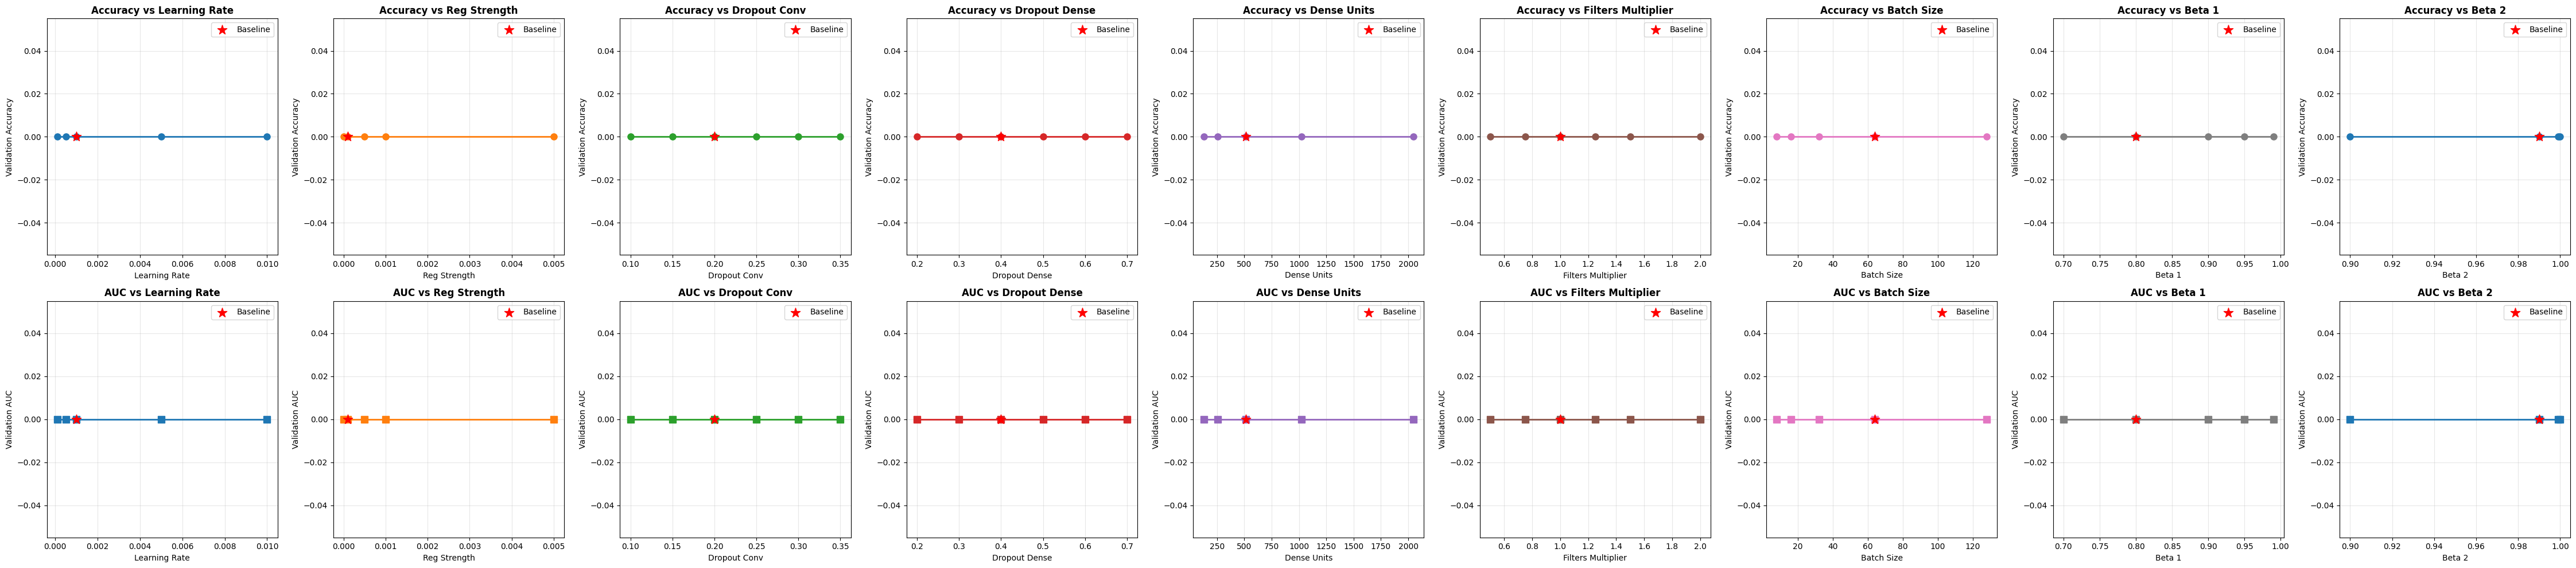


HYPERPARAMETER SENSITIVITY ANALYSIS SUMMARY

Learning Rate:
  Range tested: 0.0001 - 0.01
  Baseline value: 0.001
  Best accuracy: 0.0000 (at learning_rate=0.0001)
  Worst accuracy: 0.0000 (at learning_rate=0.0001)
  Best AUC: 0.0000 (at learning_rate=0.0001)
  Worst AUC: 0.0000 (at learning_rate=0.0001)
  Accuracy range: 0.0000
  AUC range: 0.0000

Reg Strength:
  Range tested: 1e-05 - 0.005
  Baseline value: 0.0001
  Best accuracy: 0.0000 (at reg_strength=1e-05)
  Worst accuracy: 0.0000 (at reg_strength=1e-05)
  Best AUC: 0.0000 (at reg_strength=1e-05)
  Worst AUC: 0.0000 (at reg_strength=1e-05)
  Accuracy range: 0.0000
  AUC range: 0.0000

Dropout Conv:
  Range tested: 0.1 - 0.35
  Baseline value: 0.2
  Best accuracy: 0.0000 (at dropout_conv=0.1)
  Worst accuracy: 0.0000 (at dropout_conv=0.1)
  Best AUC: 0.0000 (at dropout_conv=0.1)
  Worst AUC: 0.0000 (at dropout_conv=0.1)
  Accuracy range: 0.0000
  AUC range: 0.0000

Dropout Dense:
  Range tested: 0.2 - 0.7
  Baseline value: 0.4


In [16]:
# Plot the results
if 'sensitivity_results' in locals() and len(sensitivity_results) > 0:
    plot_sensitivity_results(sensitivity_results)
else:
    print("No sensitivity results available yet. Run the sensitivity analysis first.")